# Premier League Player Role Discovery - Phase 3: PCA & Clustering

This notebook implements the unsupervised modeling pipeline for the Premier League Player Role Discovery project. It builds on the feature engineering work from Phase 2 and focuses on:

1. Principal Component Analysis (PCA) for dimensionality reduction
2. Clustering algorithms (K-Means and GMM) for player role discovery
3. UMAP for 2D visualization of player clusters

## Execution Order

The main sections are:

1. Import Libraries and Setup
2. Define Constants and Paths
3. Helper Functions
4. Data Loading and Preparation
5. Exploratory Data Analysis
6. Feature Standardization
7. Principal Component Analysis (PCA)
8. Clustering Algorithm Comparison
9. Final Cluster Assignment
10. UMAP Visualization
11. Output Files Generation
12. Summary and Next Steps

## Clusters

# Cluster 0 - "The Enforcers" (Defensive Specialists)
Premier League Examples: Rodri, Casemiro, N'Golo Kanté, Fabinho...
What They Do:
High Tackles Won: Win the ball back for their team
High Interceptions: Read the game and break up attacks
High Clearances: Get the ball away from danger
High Blocks: Stop shots and crosses
Low Goals/Assists: Focus on defensive duties, not attacking

# Cluster 1 - "The Creators" (Attacking Playmakers)
Premier League Examples: Kevin De Bruyne, Bruno Fernandes, Martin Ødegaard, James Maddison...
What They Do:
High Key Passes: Deliver the final pass that leads to a chance
High Assists: Set up goals for teammates
High Through Balls: Play passes that split the defense
High Crosses: Deliver balls into the box
High Set Pieces: Take corners and free kicks

# Cluster 2 - "The Finishers" (Goal Threats)
Premier League Examples: Erling Haaland, Mohamed Salah, Son Heung-min, Harry Kane...
What They Do:
High Shots on Target: Test the goalkeeper regularly
High Goals: Find the back of the net
High Touches in Box: Get into dangerous scoring positions
High Dribbles: Take on defenders
High Progressive Carries: Move the ball forward with purpose




## 1. Import Libraries and Setup


In [27]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Tuple, Union, Any

# for dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# for clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.model_selection import StratifiedKFold

# for visualization
import umap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# for stability assessment
from sklearn.utils import resample

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# set display options for better dataframe viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

# set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14


## 2. Define Constants and Paths


In [28]:
# input/output paths
INPUT_FILE = '../data/processed/player_stats_engineered.csv'
OUTPUT_DIR = '../data/processed/'

PCA_OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'player_pca_projection.csv')
CLUSTERS_OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'player_clusters.csv')
UMAP_OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'player_umap_2d.csv')

# create output director
os.makedirs(OUTPUT_DIR, exist_ok=True)

# columns to exclude from analysis (identifier columns)
ID_COLUMNS = [
    'player', 'team', 'position', 'nation', 'data_source', 'row_id',
    'nation_misc', 'position_misc', 'team_misc',
    'nation_passing', 'position_passing', 'team_passing',
    'nation_playtime', 'position_playtime', 'team_playtime',
    'nation_defense', 'position_defense', 'team_defense',
    'nation_pass_types', 'position_pass_types', 'team_pass_types',
    'nation_creation', 'position_creation', 'team_creation',
    'nation_possession', 'position_possession', 'team_possession',
    'nation_shooting', 'position_shooting', 'team_shooting'
]

# PCA parameters
PCA_VARIANCE_TARGET = 0.90  # retain 90% of variance

# clustering parameters
K_RANGE = range(3, 16)  # test from 3 to 15 clusters
SILHOUETTE_THRESHOLD = 0.18  # minimum acceptable silhouette score
DAVIES_BOULDIN_THRESHOLD = 1.6  # maximum acceptable davies-bouldin index
ARI_THRESHOLD = 0.70  # minimum acceptable adjusted rand index

# bootstrap parameters
N_BOOTSTRAPS = 50  # number of bootstrap samples for stability assessment

# UMAP parameters
UMAP_N_NEIGHBORS = 15
UMAP_MIN_DIST = 0.1
UMAP_N_COMPONENTS = 2


## 3. Helper Functions


In [29]:
# PCA helper functions
def apply_pca(data: pd.DataFrame, variance_target: float = 0.9, 
              random_state: int = 42) -> Tuple[PCA, np.ndarray]:
    """
    apply pca to the data and return the fitted pca object and transformed data
    
    args:
        data: dataframe with features
        variance_target: target explained variance (default: 0.9)
        random_state: random seed for reproducibility
        
    returns:
        pca: fitted pca object
        transformed_data: data transformed to principal components
    """
    # initialize pca with a high number of components
    pca = PCA(random_state=random_state)
    
    # fit pca to the data
    transformed_data = pca.fit_transform(data)
    
    # calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # find number of components needed to reach target variance
    n_components = np.argmax(cumulative_variance >= variance_target) + 1
    
    # re-initialize pca with the determined number of components
    pca = PCA(n_components=n_components, random_state=random_state)
    transformed_data = pca.fit_transform(data)
    
    print(f"PCA with {n_components} components explains {pca.explained_variance_ratio_.sum():.4f} of variance")
    
    return pca, transformed_data

def plot_explained_variance(pca: PCA, figsize: Tuple[int, int] = (12, 6)) -> plt.Figure:
    """
    create a scree plot showing explained variance by principal components
    
    args:
        pca: fitted pca object
        figsize: figure size as (width, height)
        
    returns:
        fig: matplotlib figure object
    """
    # calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # plot individual explained variance
    ax1.bar(range(1, len(pca.explained_variance_ratio_) + 1), 
            pca.explained_variance_ratio_, alpha=0.7, color='skyblue')
    ax1.set_xlabel('principal component')
    ax1.set_ylabel('explained variance ratio')
    ax1.set_title('individual explained variance')
    
    # plot cumulative explained variance
    ax2.plot(range(1, len(cumulative_variance) + 1), 
             cumulative_variance, marker='o', linestyle='-', color='royalblue')
    ax2.axhline(y=0.9, color='r', linestyle='--', alpha=0.7, label='90% variance threshold')
    ax2.set_xlabel('number of components')
    ax2.set_ylabel('cumulative explained variance')
    ax2.set_title('cumulative explained variance')
    ax2.legend()
    
    plt.tight_layout()
    return fig

def plot_component_loadings(pca: PCA, feature_names: List[str], 
                           n_components: int = 3, n_features: int = 10, 
                           figsize: Tuple[int, int] = (15, 12)) -> plt.Figure:
    """
    visualize the top feature contributions to principal components
    
    args:
        pca: fitted pca object
        feature_names: list of feature names
        n_components: number of components to show (default: 3)
        n_features: number of top features to show per component (default: 10)
        figsize: figure size as (width, height)
        
    returns:
        fig: matplotlib figure object
    """
    n_components = min(n_components, pca.n_components_)
    
    # create figure with subplots
    fig, axes = plt.subplots(n_components, 1, figsize=figsize)
    if n_components == 1:
        axes = [axes]
    
    # for each component
    for i, ax in enumerate(axes):
        if i < n_components:
            # get the loadings
            loadings = pca.components_[i]
            
            # get indices of top positive and negative loadings
            sorted_indices = np.argsort(np.abs(loadings))
            top_indices = sorted_indices[-n_features:]
            
            # get feature names and values
            top_features = [feature_names[j] for j in top_indices]
            top_loadings = [loadings[j] for j in top_indices]
            
            # create horizontal bar chart
            bars = ax.barh(top_features, top_loadings, color=['red' if x < 0 else 'green' for x in top_loadings])
            ax.set_title(f'principal component {i+1} (variance explained: {pca.explained_variance_ratio_[i]:.4f})')
            ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
            ax.set_xlabel('loading value')
    
    plt.tight_layout()
    return fig

# clustering helper functions
def evaluate_kmeans(data: np.ndarray, k_range: range = range(2, 11), 
                   random_state: int = 42) -> Tuple[Dict, plt.Figure]:
    """
    evaluate k-means clustering for a range of k values
    
    args:
        data: data matrix to cluster
        k_range: range of k values to test
        random_state: random seed for reproducibility
        
    returns:
        results: dictionary with evaluation metrics
        fig: matplotlib figure with evaluation plots
    """
    inertia_values = []
    silhouette_values = []
    davies_bouldin_values = []
    
    results = {
        'k_values': list(k_range),
        'inertia': [],
        'silhouette': [],
        'davies_bouldin': [],
        'models': {}
    }
    
    for k in k_range:
        print(f"Evaluating K-Means with k={k}...")
        
        # fit kmeans
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        
        # calculate metrics
        inertia = kmeans.inertia_
        
        # silhouette score requires at least 2 clusters and samples per cluster
        try:
            silhouette = silhouette_score(data, cluster_labels)
        except:
            silhouette = 0
            
        # davies-bouldin score
        try:
            davies_bouldin = davies_bouldin_score(data, cluster_labels)
        except:
            davies_bouldin = float('inf')
            
        # store results
        results['inertia'].append(inertia)
        results['silhouette'].append(silhouette)
        results['davies_bouldin'].append(davies_bouldin)
        results['models'][k] = kmeans
        
    # create evaluation plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # plot inertia (elbow method)
    ax1.plot(k_range, results['inertia'], marker='o', linestyle='-')
    ax1.set_xlabel('number of clusters (k)')
    ax1.set_ylabel('inertia')
    ax1.set_title('elbow method')
    
    # plot silhouette scores
    ax2.plot(k_range, results['silhouette'], marker='o', linestyle='-')
    ax2.axhline(y=SILHOUETTE_THRESHOLD, color='r', linestyle='--', alpha=0.7, 
                label=f'threshold: {SILHOUETTE_THRESHOLD}')
    ax2.set_xlabel('number of clusters (k)')
    ax2.set_ylabel('silhouette score')
    ax2.set_title('silhouette evaluation')
    ax2.legend()
    
    # plot davies-bouldin index
    ax3.plot(k_range, results['davies_bouldin'], marker='o', linestyle='-')
    ax3.axhline(y=DAVIES_BOULDIN_THRESHOLD, color='r', linestyle='--', alpha=0.7,
               label=f'threshold: {DAVIES_BOULDIN_THRESHOLD}')
    ax3.set_xlabel('number of clusters (k)')
    ax3.set_ylabel('davies-bouldin index')
    ax3.set_title('davies-bouldin evaluation')
    ax3.legend()
    
    plt.tight_layout()
    
    return results, fig

def evaluate_gmm(data: np.ndarray, k_range: range = range(2, 11), 
                random_state: int = 42) -> Tuple[Dict, plt.Figure]:
    """
    evaluate gaussian mixture models for a range of components
    
    args:
        data: data matrix to cluster
        k_range: range of component values to test
        random_state: random seed for reproducibility
        
    returns:
        results: dictionary with evaluation metrics
        fig: matplotlib figure with evaluation plots
    """
    results = {
        'k_values': list(k_range),
        'aic': [],
        'bic': [],
        'silhouette': [],
        'davies_bouldin': [],
        'models': {}
    }
    
    for k in k_range:
        print(f"Evaluating GMM with components={k}...")
        
        # fit gmm
        gmm = GaussianMixture(n_components=k, random_state=random_state, n_init=10)
        gmm.fit(data)
        cluster_labels = gmm.predict(data)
        
        # calculate metrics
        aic = gmm.aic(data)
        bic = gmm.bic(data)
        
        # silhouette score
        try:
            silhouette = silhouette_score(data, cluster_labels)
        except:
            silhouette = 0
            
        # davies-bouldin score
        try:
            davies_bouldin = davies_bouldin_score(data, cluster_labels)
        except:
            davies_bouldin = float('inf')
            
        # store results
        results['aic'].append(aic)
        results['bic'].append(bic)
        results['silhouette'].append(silhouette)
        results['davies_bouldin'].append(davies_bouldin)
        results['models'][k] = gmm
        
    # create evaluation plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # plot information criteria
    ax1.plot(k_range, results['aic'], marker='o', linestyle='-', label='AIC')
    ax1.plot(k_range, results['bic'], marker='s', linestyle='-', label='BIC')
    ax1.set_xlabel('number of components')
    ax1.set_ylabel('information criterion')
    ax1.set_title('AIC and BIC evaluation')
    ax1.legend()
    
    # plot silhouette scores
    ax2.plot(k_range, results['silhouette'], marker='o', linestyle='-')
    ax2.axhline(y=SILHOUETTE_THRESHOLD, color='r', linestyle='--', alpha=0.7, 
                label=f'threshold: {SILHOUETTE_THRESHOLD}')
    ax2.set_xlabel('number of components')
    ax2.set_ylabel('silhouette score')
    ax2.set_title('silhouette evaluation')
    ax2.legend()
    
    # plot davies-bouldin index
    ax3.plot(k_range, results['davies_bouldin'], marker='o', linestyle='-')
    ax3.axhline(y=DAVIES_BOULDIN_THRESHOLD, color='r', linestyle='--', alpha=0.7,
               label=f'threshold: {DAVIES_BOULDIN_THRESHOLD}')
    ax3.set_xlabel('number of components')
    ax3.set_ylabel('davies-bouldin index')
    ax3.set_title('davies-bouldin evaluation')
    ax3.legend()
    
    plt.tight_layout()
    
    return results, fig

def assess_clustering_stability(data: np.ndarray, model, 
                               n_bootstraps: int = 50, sample_size: float = 0.8,
                               random_state: int = 42) -> float:
    """
    assess clustering stability using bootstrap sampling and adjusted rand index
    
    args:
        data: data matrix to cluster
        model: clustering model with fit_predict method
        n_bootstraps: number of bootstrap samples
        sample_size: fraction of data to sample
        random_state: random seed for reproducibility
        
    returns:
        mean_ari: mean adjusted rand index across bootstrap samples
    """
    np.random.seed(random_state)
    n_samples = int(data.shape[0] * sample_size)
    ari_scores = []
    
    # get reference clustering on full dataset
    reference_labels = model.fit_predict(data)
    
    for i in range(n_bootstraps):
        # create bootstrap sample
        indices = resample(range(data.shape[0]), n_samples=n_samples, replace=True)
        bootstrap_data = data[indices]
        
        # fit model to bootstrap sample
        bootstrap_labels = model.fit_predict(bootstrap_data)
        
        # map bootstrap labels back to original indices
        full_labels = np.zeros(data.shape[0]) - 1  # -1 for non-sampled points
        for j, idx in enumerate(indices):
            full_labels[idx] = bootstrap_labels[j]
        
        # calculate ARI only on sampled points
        sampled_mask = full_labels >= 0
        if sum(sampled_mask) > 0:  # ensure we have sampled points
            ari = adjusted_rand_score(reference_labels[sampled_mask], full_labels[sampled_mask])
            ari_scores.append(ari)
    
    mean_ari = np.mean(ari_scores) if ari_scores else 0
    return mean_ari

# UMAP helper functions
def apply_umap(data: np.ndarray, n_neighbors: int = 15, min_dist: float = 0.1,
              n_components: int = 2, random_state: int = 42) -> np.ndarray:
    """
    apply umap dimensionality reduction
    
    args:
        data: data matrix to project
        n_neighbors: number of neighbors to consider
        min_dist: minimum distance between points in embedding
        n_components: number of dimensions in embedding
        random_state: random seed for reproducibility
        
    returns:
        embedding: umap embedding of the data
    """
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        random_state=random_state
    )
    
    embedding = reducer.fit_transform(data)
    return embedding

def plot_umap_clusters(embedding: np.ndarray, labels: np.ndarray, 
                      player_names: Optional[List[str]] = None) -> go.Figure:
    """
    create an interactive scatter plot of umap embedding colored by cluster
    
    args:
        embedding: 2d umap embedding
        labels: cluster labels
        player_names: optional list of player names for hover text
        
    returns:
        fig: plotly figure object
    """
    df = pd.DataFrame({
        'x': embedding[:, 0],
        'y': embedding[:, 1],
        'cluster': labels.astype(str)
    })
    
    if player_names is not None:
        df['player'] = player_names
    
    fig = px.scatter(
        df, x='x', y='y', color='cluster',
        hover_data=['player'] if player_names is not None else None,
        title='UMAP Projection of Player Clusters',
        labels={'x': 'UMAP Dimension 1', 'y': 'UMAP Dimension 2'},
        color_discrete_sequence=px.colors.qualitative.G10
    )
    
    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(
        legend_title_text='Cluster',
        plot_bgcolor='white',
        width=900,
        height=700
    )
    
    return fig


## 4. Data Loading and Preparation


In [30]:
# load the engineered dataset
print(f"Loading data from {INPUT_FILE}...")
try:
    df = pd.read_csv(INPUT_FILE)
    print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# check for missing values
missing_values = df.isnull().sum().sum()
print(f"Total missing values: {missing_values}")

if missing_values > 0:
    print("Columns with missing values:")
    missing_cols = df.columns[df.isnull().any()].tolist()
    for col in missing_cols:
        missing_count = df[col].isnull().sum()
        missing_pct = missing_count / len(df) * 100
        print(f"  - {col}: {missing_count} missing values ({missing_pct:.2f}%)")

# separate identifier columns from features
id_df = df[list(set(ID_COLUMNS).intersection(set(df.columns)))]
print(f"Extracted {id_df.shape[1]} identifier columns")

# drop identifier columns and keep only numeric columns for analysis
feature_df = df.drop(columns=list(set(ID_COLUMNS).intersection(set(df.columns))))
numeric_df = feature_df.select_dtypes(include=[np.number])
print(f"Retained {numeric_df.shape[1]} numeric feature columns for analysis")

# check for any remaining non-numeric columns
non_numeric_cols = set(feature_df.columns) - set(numeric_df.columns)
if non_numeric_cols:
    print(f"Warning: {len(non_numeric_cols)} non-numeric columns were dropped:")
    print(f"  {', '.join(non_numeric_cols)}")

# check for any remaining missing values in numeric features
missing_in_numeric = numeric_df.isnull().sum().sum()
if missing_in_numeric > 0:
    print(f"Warning: {missing_in_numeric} missing values in numeric features")
    print("Filling missing values with column medians...")
    numeric_df = numeric_df.fillna(numeric_df.median())

print(f"Final feature matrix shape: {numeric_df.shape}")

# save player names for later reference
player_names = df['player'].tolist() if 'player' in df.columns else None


Loading data from ../data/processed/player_stats_engineered.csv...
Loaded 563 rows and 266 columns
Total missing values: 1310
Columns with missing values:
  - nation: 4 missing values (0.71%)
  - nation_misc: 4 missing values (0.71%)
  - wonpct: 42 missing values (7.46%)
  - nation_passing: 4 missing values (0.71%)
  - cmppct3: 42 missing values (7.46%)
  - nation_playtime: 4 missing values (0.71%)
  - mn_per_start: 71 missing values (12.61%)
  - mn_per_sub: 83 missing values (14.74%)
  - nation_defense: 4 missing values (0.71%)
  - tklpct: 53 missing values (9.41%)
  - nation_pass_types: 4 missing values (0.71%)
  - nation_creation: 4 missing values (0.71%)
  - nation_possession: 4 missing values (0.71%)
  - succpct: 84 missing values (14.92%)
  - tkldpct: 84 missing values (14.92%)
  - nation_shooting: 4 missing values (0.71%)
  - sotpct: 106 missing values (18.83%)
  - g_per_sh: 106 missing values (18.83%)
  - g_per_sot: 176 missing values (31.26%)
  - dist: 106 missing values (18.8

## 5. Exploratory Data Analysis


Basic statistics of the feature matrix:
Min values range: [-0.7562, 1991.0000]
Max values range: [0.0000, 27219.0000]
Mean values range: [-0.0003, 8819.1510]
Std values range: [0.0000, 8256.0324]
  pk, 2crdy, og, pk_shooting
Dropping zero variance features...
Feature matrix shape after dropping zero variance features: (563, 232)

Analyzing feature correlations...
Number of highly correlated feature pairs (|r| > 0.8): 1647

Correlation matrix of composite indices:
           PI       CCI        DA        FE
PI   1.000000  0.637871  0.252823  0.044981
CCI  0.637871  1.000000  0.091746  0.118944
DA   0.252823  0.091746  1.000000 -0.125660
FE   0.044981  0.118944 -0.125660  1.000000


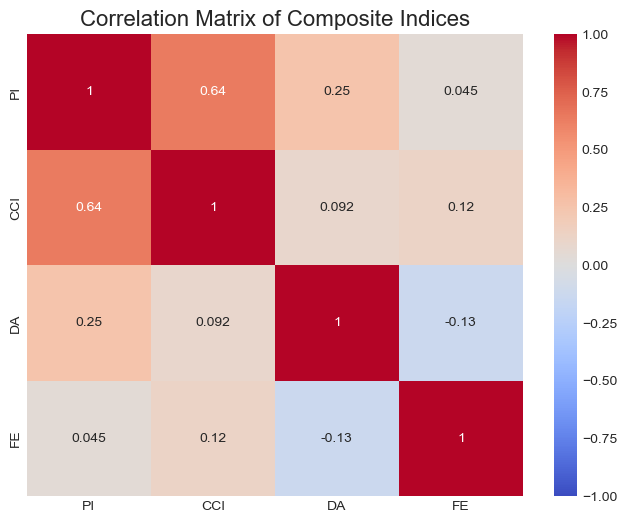


Visualizing distribution of key features...


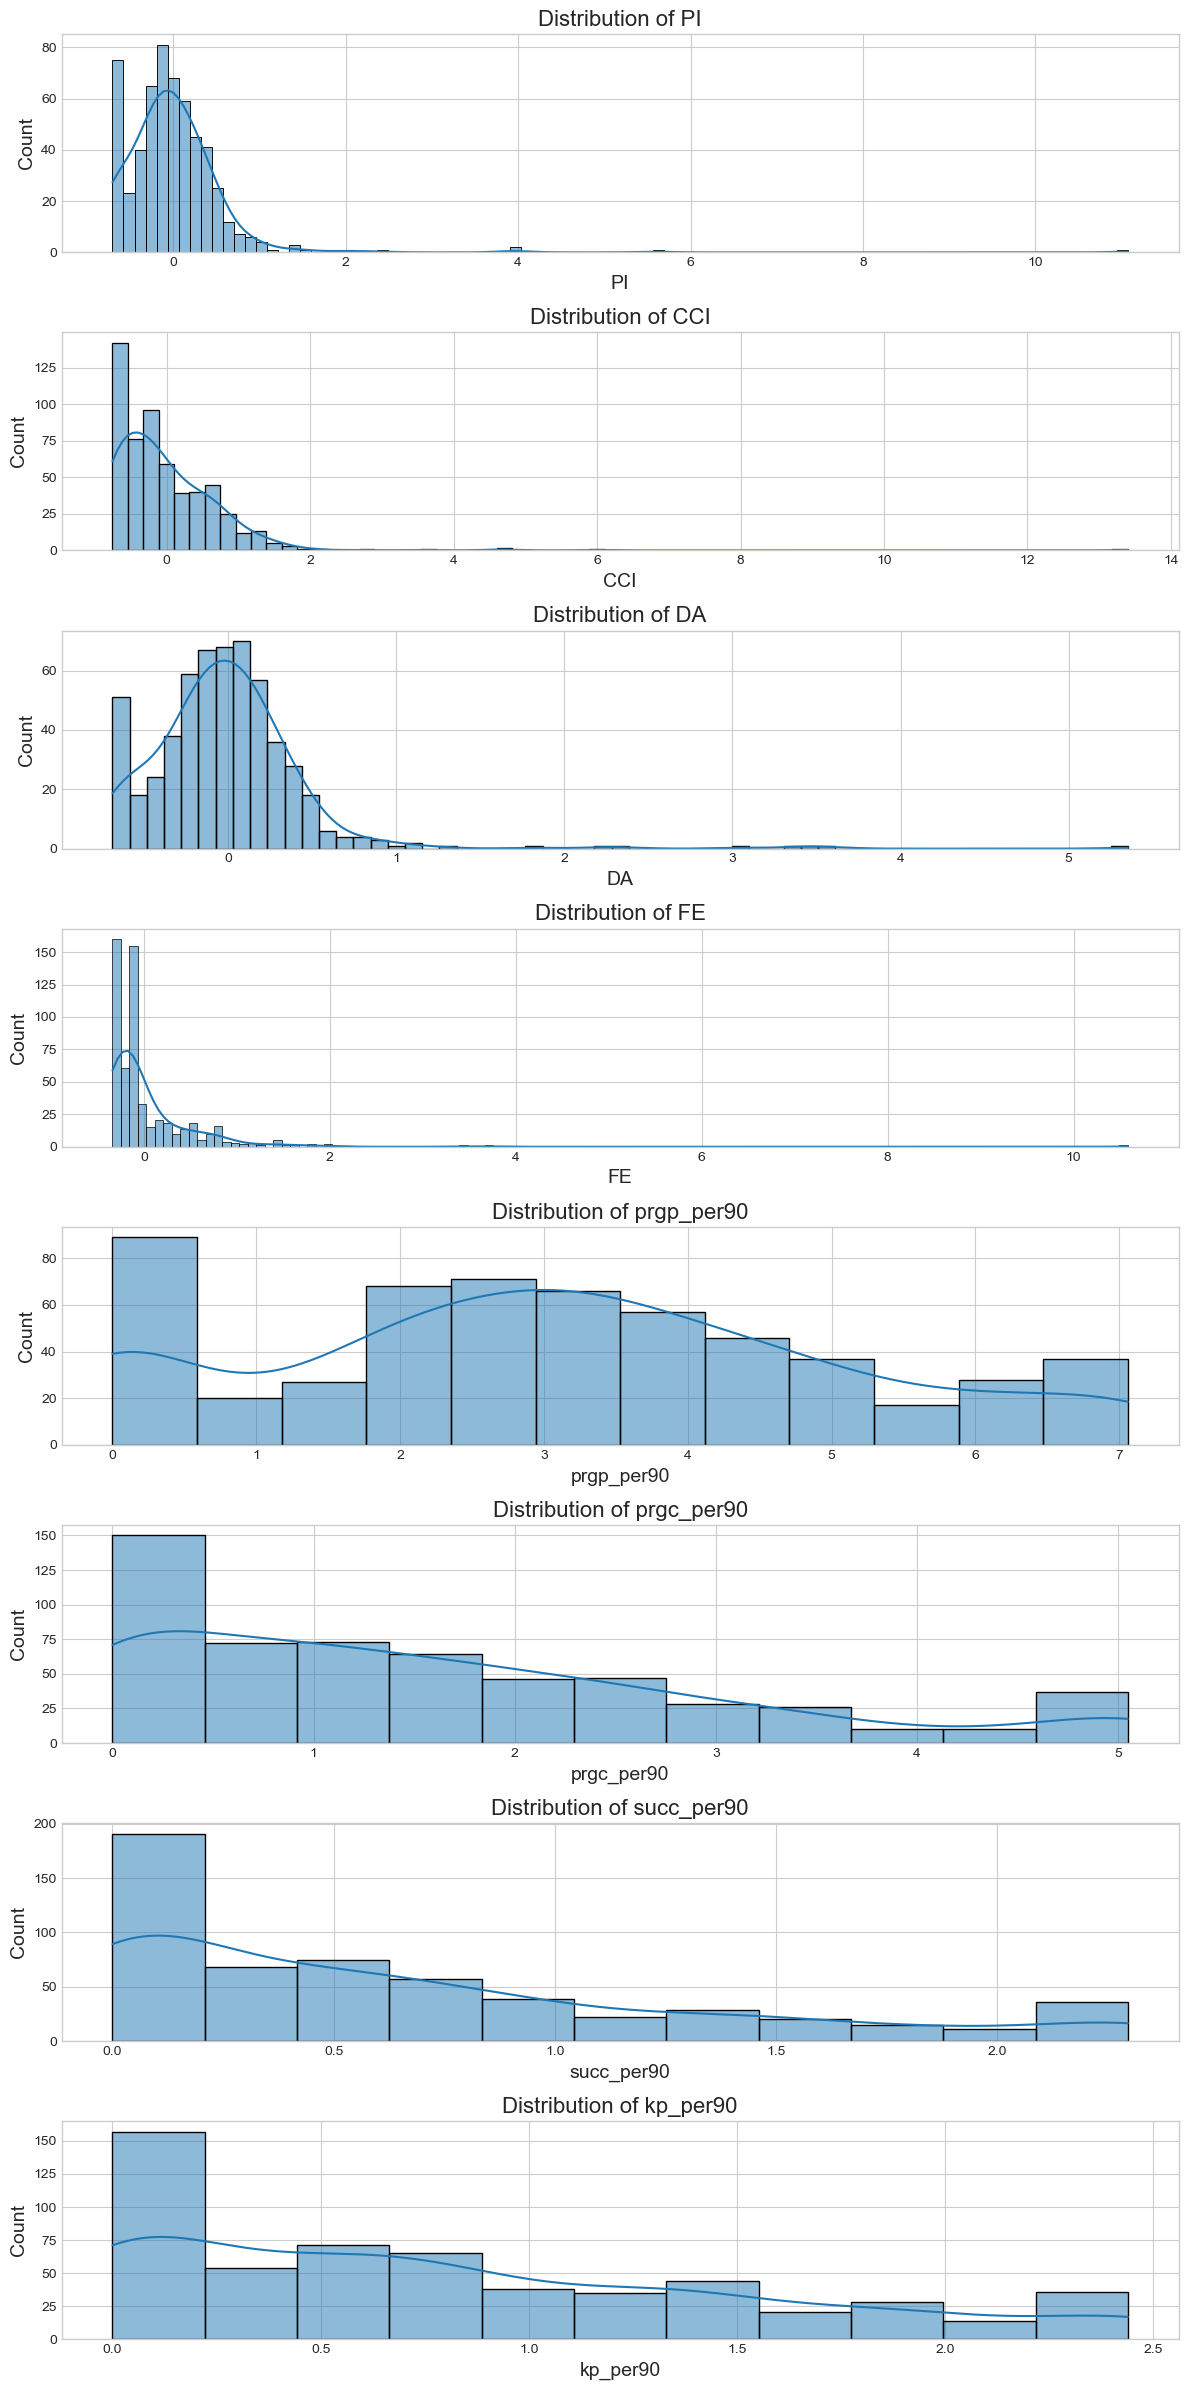

In [31]:
# basic statistics of the feature matrix
print("Basic statistics of the feature matrix:")
basic_stats = numeric_df.describe().T
print(f"Min values range: [{basic_stats['min'].min():.4f}, {basic_stats['min'].max():.4f}]")
print(f"Max values range: [{basic_stats['max'].min():.4f}, {basic_stats['max'].max():.4f}]")
print(f"Mean values range: [{basic_stats['mean'].min():.4f}, {basic_stats['mean'].max():.4f}]")
print(f"Std values range: [{basic_stats['std'].min():.4f}, {basic_stats['std'].max():.4f}]")

# check for features with zero variance
zero_var_features = numeric_df.columns[numeric_df.var() == 0].tolist()
if zero_var_features:
    print(f"Warning: {len(zero_var_features)} features have zero variance:")
    print(f"  {', '.join(zero_var_features)}")
    print("Dropping zero variance features...")
    numeric_df = numeric_df.drop(columns=zero_var_features)
    print(f"Feature matrix shape after dropping zero variance features: {numeric_df.shape}")

# analyze feature correlations
print("\nAnalyzing feature correlations...")
corr_matrix = numeric_df.corr()

# count highly correlated features (|r| > 0.8)
high_corr_count = (np.abs(corr_matrix) > 0.8).sum().sum() - numeric_df.shape[1]  # exclude self-correlations
print(f"Number of highly correlated feature pairs (|r| > 0.8): {high_corr_count // 2}")  # divide by 2 to count each pair once

# visualize correlation matrix of composite indices
if all(idx in numeric_df.columns for idx in ['PI', 'CCI', 'DA', 'FE']):
    print("\nCorrelation matrix of composite indices:")
    indices_corr = numeric_df[['PI', 'CCI', 'DA', 'FE']].corr()
    print(indices_corr)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(indices_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Matrix of Composite Indices')
    plt.show()

# visualize distribution of a few key features
print("\nVisualizing distribution of key features...")
key_features = []

# try to find composite indices
for idx in ['PI', 'CCI', 'DA', 'FE']:
    if idx in numeric_df.columns:
        key_features.append(idx)

# add some per90 features if available
per90_cols = [col for col in numeric_df.columns if 'per90' in col]
if per90_cols:
    # select a few representative per90 features
    sample_per90 = per90_cols[:min(4, len(per90_cols))]
    key_features.extend(sample_per90)

# limit to at most 8 features
key_features = key_features[:8]

if key_features:
    fig, axes = plt.subplots(len(key_features), 1, figsize=(12, 3*len(key_features)))
    if len(key_features) == 1:
        axes = [axes]
        
    for i, feature in enumerate(key_features):
        sns.histplot(numeric_df[feature].dropna(), kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        
    plt.tight_layout()
    plt.show()


## 6. Feature Standardization


In [32]:
# standardize features (zero mean and unit variance)
print("Standardizing features...")
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# verify standardization
scaled_mean = scaled_data.mean(axis=0)
scaled_std = scaled_data.std(axis=0)

print(f"Mean after standardization: range [{scaled_mean.min():.6f}, {scaled_mean.max():.6f}]")
print(f"Std after standardization: range [{scaled_std.min():.6f}, {scaled_std.max():.6f}]")

# check for any issues in standardization (e.g., NaN or Inf values)
if np.isnan(scaled_data).any() or np.isinf(scaled_data).any():
    print("Warning: NaN or Inf values found in standardized data")
    # replace NaN or Inf with 0
    scaled_data = np.nan_to_num(scaled_data)
    print("Replaced NaN/Inf values with 0")

# create DataFrame with standardized values for easier reference
scaled_df = pd.DataFrame(scaled_data, columns=numeric_df.columns)

print("Standardization completed successfully")

# display sample of standardized data
print("\nSample of standardized data:")
print(scaled_df.head())


Standardizing features...
Mean after standardization: range [-0.000000, 0.000000]
Std after standardization: range [1.000000, 1.000000]
Standardization completed successfully

Sample of standardized data:
         rk       age      born        mp    starts   minutes       90s       gls       ast    gplusa      g_pk    pkatt      crdy      crdr        xg      npxg       xag  npxgplusxag      prgc      prgp      prgr      gls1      ast1   gplusa1     g_pk1  gplusa_pk       xg1      xag1  xgplusxag     npxg1  npxgplusxag1  row_id_misc   rk_misc  age_misc  born_misc  90s_misc  crdy_misc  crdr_misc       fls       fld       off       crs       int      tklw     pkwon     pkcon     recov       won      lost    wonpct  row_id_passing  rk_passing  age_passing  born_passing  90s_passing       cmp       att    cmppct   totdist   prgdist      cmp1      att1   cmppct1      cmp2      att2   cmppct2      cmp3      att3   cmppct3  ast_passing  xag_passing        xa     a_xag        kp   1_per_3      

## 7. Principal Component Analysis (PCA)


Applying PCA with target variance: 0.9...
PCA with 31 components explains 0.9017 of variance

Sample of PCA results:
               player        PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8       PC9      PC10      PC11      PC12      PC13      PC14      PC15      PC16      PC17      PC18      PC19      PC20      PC21      PC22      PC23      PC24      PC25      PC26      PC27      PC28      PC29      PC30      PC31
0     Aaron Cresswell  -3.762090 -4.138493 -2.270277 -7.689105  5.028207 -0.456768  0.501506  0.989276 -0.112329  0.460909 -1.241242 -0.571615  0.153901 -1.202833 -0.131503  0.564420 -0.592587  0.000836  0.968487  0.079783 -0.223477 -0.192671  1.559156  0.526799 -0.981836  0.362874  0.289294  0.000468  0.569729 -0.329798  0.407061
1      Aaron Ramsdale  -1.517380 -8.768691 -3.782109  2.051832 -4.859509 -7.261049  1.362068  0.347736 -2.740805 -1.498965  1.980678  2.956220  0.775806 -0.189168 -0.621065 -2.489497  0.157978 -0.684280 -0.216387 -0.6

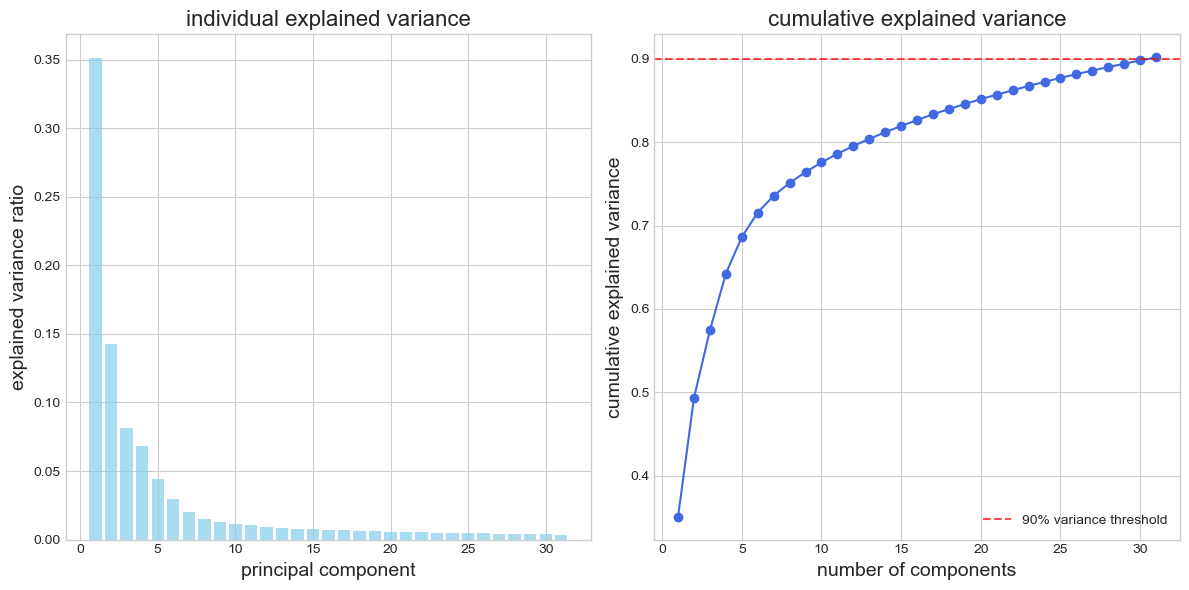


Generating component loadings plot...


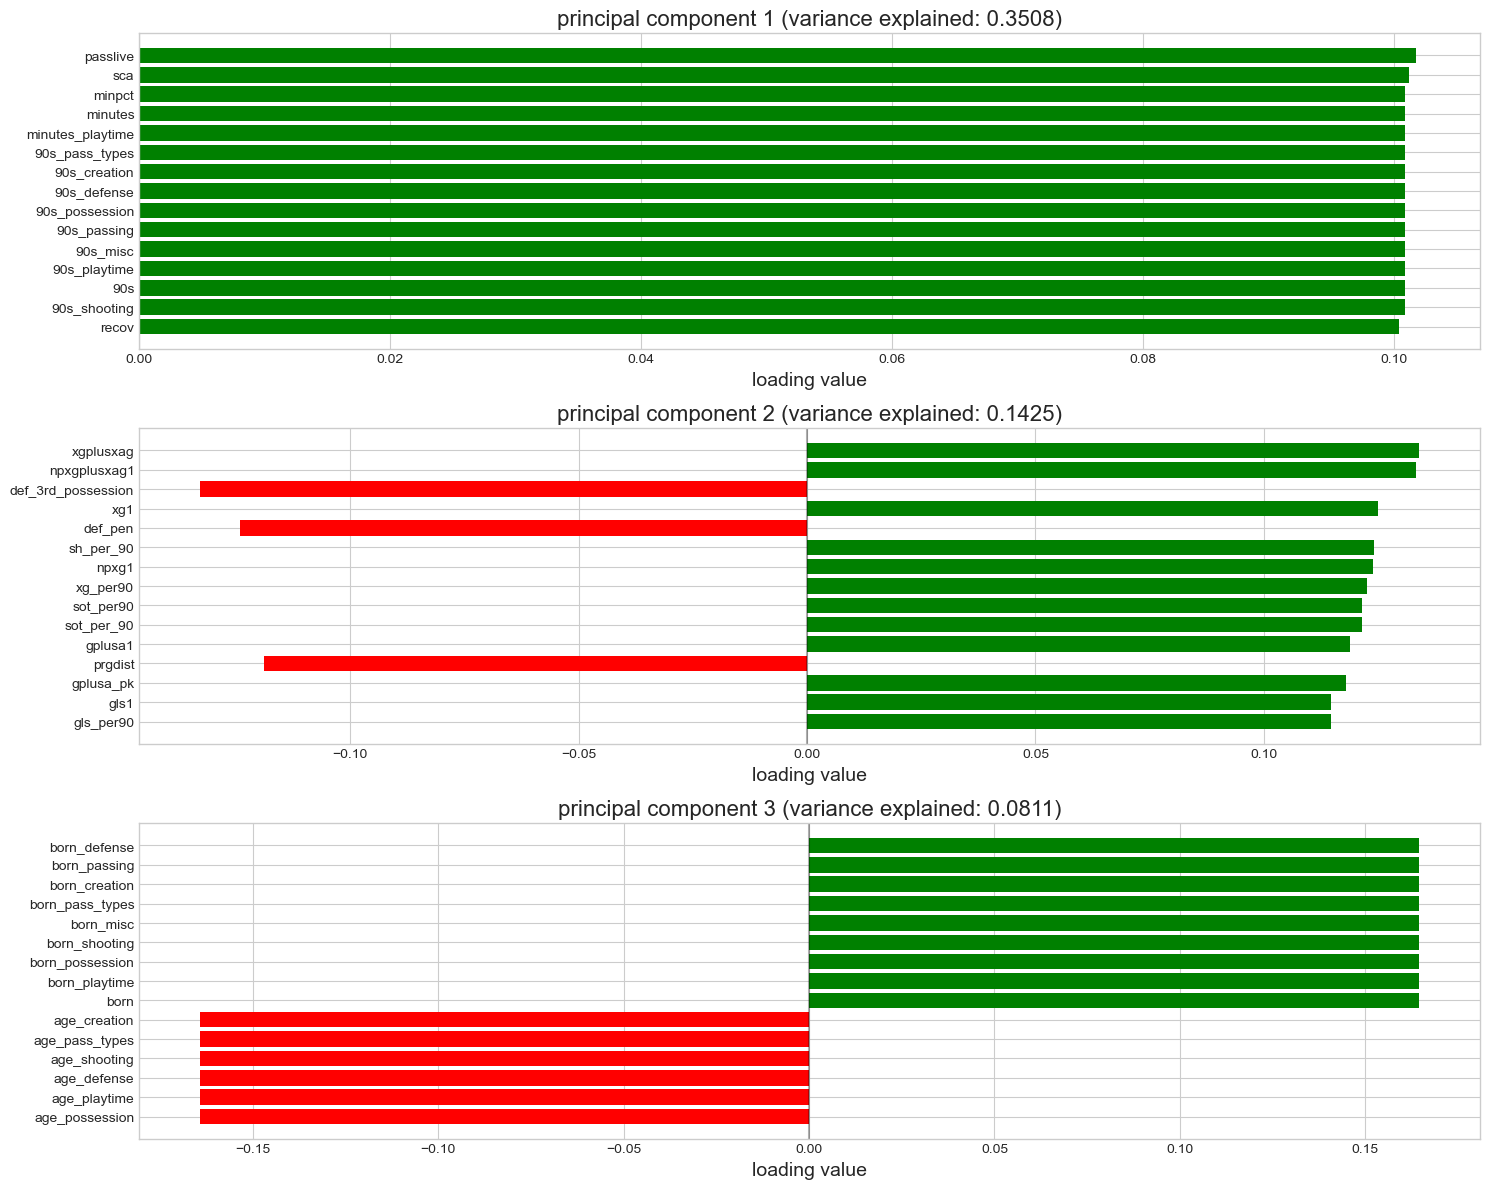


Saving PCA projection to ../data/processed/player_pca_projection.csv...
Saved PCA projection with 32 components
PCA completed successfully


In [33]:
# apply pca to standardized data
print(f"Applying PCA with target variance: {PCA_VARIANCE_TARGET}...")
pca, pca_data = apply_pca(scaled_data, variance_target=PCA_VARIANCE_TARGET, random_state=RANDOM_STATE)

# create dataframe with pca results
pca_df = pd.DataFrame(
    pca_data, 
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# add player names if available
if player_names is not None:
    pca_df.insert(0, 'player', player_names)
    
# display sample of pca results
print("\nSample of PCA results:")
print(pca_df.head())

# plot explained variance
print("\nGenerating explained variance plot...")
explained_variance_plot = plot_explained_variance(pca)
plt.show()

# plot component loadings for the first few components
print("\nGenerating component loadings plot...")
loadings_plot = plot_component_loadings(pca, numeric_df.columns, n_components=3, n_features=15)
plt.show()

# save pca projection to csv
print(f"\nSaving PCA projection to {PCA_OUTPUT_FILE}...")
pca_df.to_csv(PCA_OUTPUT_FILE, index=False)
print(f"Saved PCA projection with {pca_df.shape[1]} components")

# save pca object for later use (optional)
print("PCA completed successfully")


## 8. Clustering Algorithm Comparison


### 8.1 K-Means Clustering


Evaluating K-Means clustering for k in 3..15...
Evaluating K-Means with k=3...
Evaluating K-Means with k=4...
Evaluating K-Means with k=5...
Evaluating K-Means with k=6...
Evaluating K-Means with k=7...
Evaluating K-Means with k=8...
Evaluating K-Means with k=9...
Evaluating K-Means with k=10...
Evaluating K-Means with k=11...
Evaluating K-Means with k=12...
Evaluating K-Means with k=13...
Evaluating K-Means with k=14...
Evaluating K-Means with k=15...


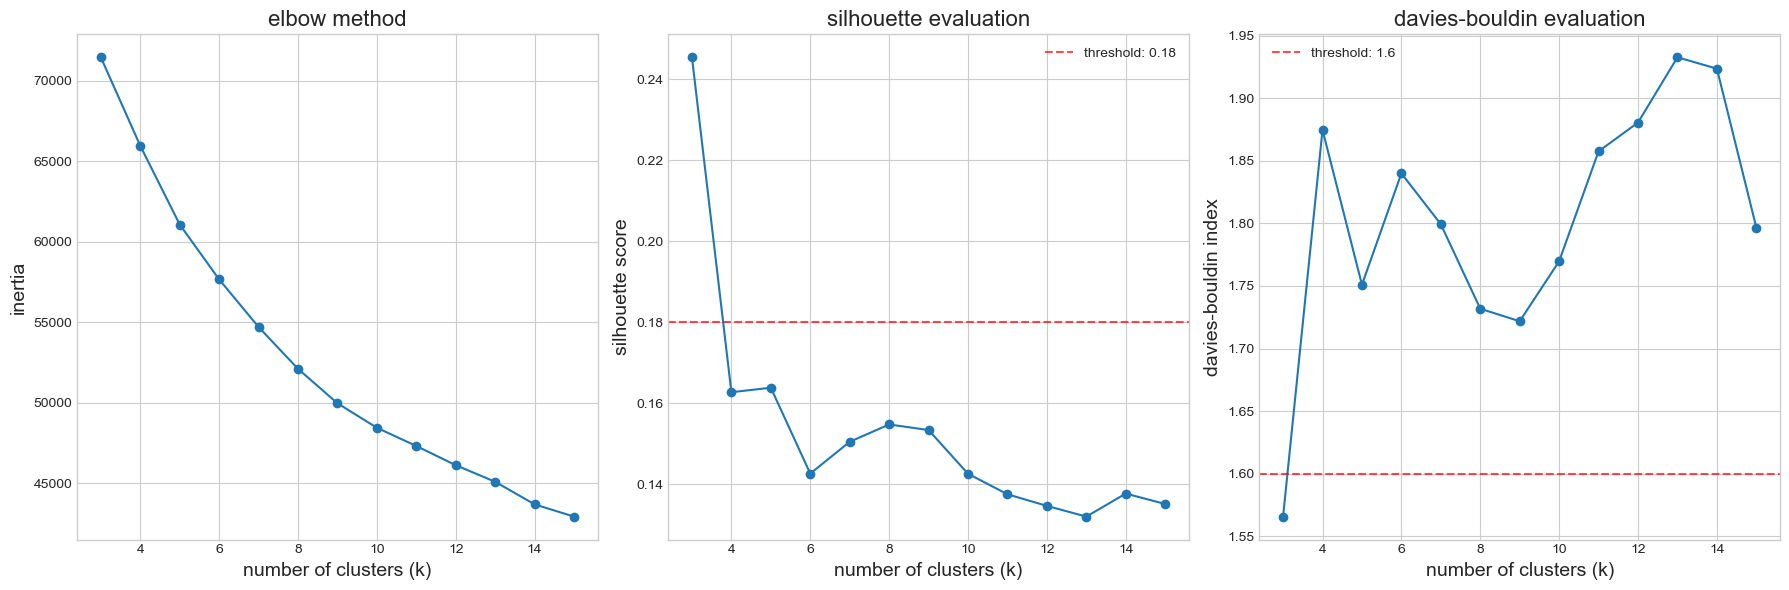


K values meeting silhouette threshold:
  Silhouette >= 0.18: [3]

K values meeting Davies-Bouldin threshold:
  Davies-Bouldin <= 1.6: [3]

K values meeting both thresholds: [3]

Selected optimal k = 3

Assessing clustering stability with 50 bootstrap samples...
K-Means stability (ARI): 0.9143
K-Means clustering with k=3 meets stability threshold (ARI >= 0.7)


In [34]:
# evaluate k-means clustering for a range of k values
print(f"Evaluating K-Means clustering for k in {min(K_RANGE)}..{max(K_RANGE)}...")
kmeans_results, kmeans_plots = evaluate_kmeans(pca_data, k_range=K_RANGE, random_state=RANDOM_STATE)
plt.show()

# find optimal k based on evaluation metrics
silhouette_scores = kmeans_results['silhouette']
davies_bouldin_scores = kmeans_results['davies_bouldin']

# find k values that meet thresholds
valid_silhouette_k = [k for k, score in zip(K_RANGE, silhouette_scores) if score >= SILHOUETTE_THRESHOLD]
valid_davies_bouldin_k = [k for k, score in zip(K_RANGE, davies_bouldin_scores) if score <= DAVIES_BOULDIN_THRESHOLD]

print("\nK values meeting silhouette threshold:")
print(f"  Silhouette >= {SILHOUETTE_THRESHOLD}: {valid_silhouette_k}")

print("\nK values meeting Davies-Bouldin threshold:")
print(f"  Davies-Bouldin <= {DAVIES_BOULDIN_THRESHOLD}: {valid_davies_bouldin_k}")

# find k values that meet both thresholds
valid_k_values = list(set(valid_silhouette_k).intersection(set(valid_davies_bouldin_k)))
print(f"\nK values meeting both thresholds: {valid_k_values}")

# select optimal k (if any meet thresholds)
if valid_k_values:
    # prefer smaller k if multiple values meet thresholds
    optimal_k = min(valid_k_values)
    print(f"\nSelected optimal k = {optimal_k}")
    
    # get the corresponding model
    optimal_kmeans = kmeans_results['models'][optimal_k]
    
    # assess stability with bootstrap
    print(f"\nAssessing clustering stability with {N_BOOTSTRAPS} bootstrap samples...")
    kmeans_stability = assess_clustering_stability(
        pca_data, 
        KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=10),
        n_bootstraps=N_BOOTSTRAPS
    )
    print(f"K-Means stability (ARI): {kmeans_stability:.4f}")
    
    if kmeans_stability >= ARI_THRESHOLD:
        print(f"K-Means clustering with k={optimal_k} meets stability threshold (ARI >= {ARI_THRESHOLD})")
    else:
        print(f"Warning: K-Means clustering with k={optimal_k} does not meet stability threshold")
else:
    print("\nNo k value meets both thresholds. Consider relaxing thresholds or trying a different algorithm.")
    # select k with best silhouette score as fallback
    best_silhouette_idx = np.argmax(silhouette_scores)
    optimal_k = K_RANGE[best_silhouette_idx]
    print(f"Selecting k = {optimal_k} based on best silhouette score as fallback")
    optimal_kmeans = kmeans_results['models'][optimal_k]


### 8.2 Gaussian Mixture Model (GMM) Clustering


Evaluating GMM clustering for components in 3..15...
Evaluating GMM with components=3...
Evaluating GMM with components=4...
Evaluating GMM with components=5...
Evaluating GMM with components=6...
Evaluating GMM with components=7...
Evaluating GMM with components=8...
Evaluating GMM with components=9...
Evaluating GMM with components=10...
Evaluating GMM with components=11...
Evaluating GMM with components=12...
Evaluating GMM with components=13...
Evaluating GMM with components=14...
Evaluating GMM with components=15...


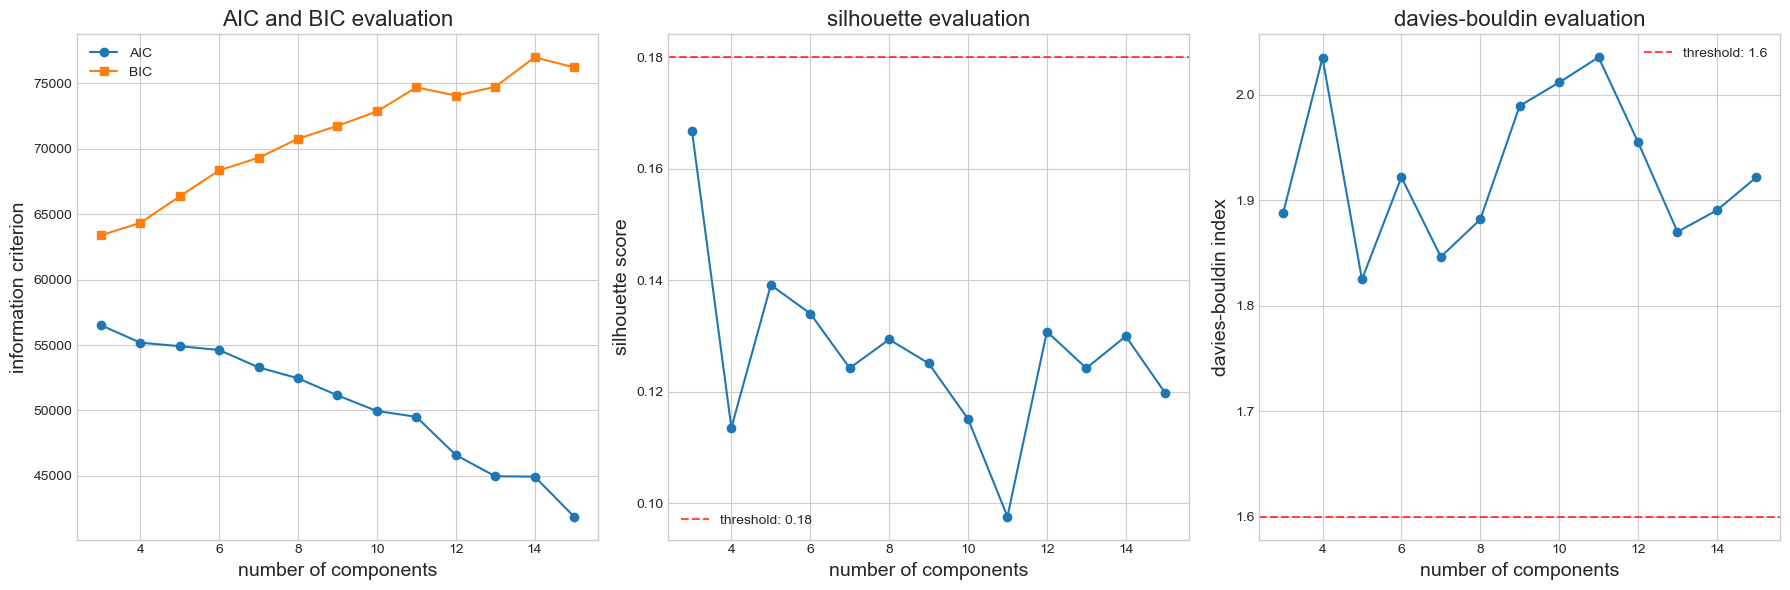


Component values meeting silhouette threshold:
  Silhouette >= 0.18: []

Component values meeting Davies-Bouldin threshold:
  Davies-Bouldin <= 1.6: []

Component values meeting both thresholds: []

No component value meets both thresholds. Need relaxing on thresholds or trying a different algorithm.
Selecting components = 3 based on best silhouette score as fallback


In [35]:
# evaluate gmm clustering for a range of component values
print(f"Evaluating GMM clustering for components in {min(K_RANGE)}..{max(K_RANGE)}...")
gmm_results, gmm_plots = evaluate_gmm(pca_data, k_range=K_RANGE, random_state=RANDOM_STATE)
plt.show()

# find optimal components based on evaluation metrics
silhouette_scores = gmm_results['silhouette']
davies_bouldin_scores = gmm_results['davies_bouldin']
aic_scores = gmm_results['aic']
bic_scores = gmm_results['bic']

# find component values that meet thresholds
valid_silhouette_k = [k for k, score in zip(K_RANGE, silhouette_scores) if score >= SILHOUETTE_THRESHOLD]
valid_davies_bouldin_k = [k for k, score in zip(K_RANGE, davies_bouldin_scores) if score <= DAVIES_BOULDIN_THRESHOLD]

print("\nComponent values meeting silhouette threshold:")
print(f"  Silhouette >= {SILHOUETTE_THRESHOLD}: {valid_silhouette_k}")

print("\nComponent values meeting Davies-Bouldin threshold:")
print(f"  Davies-Bouldin <= {DAVIES_BOULDIN_THRESHOLD}: {valid_davies_bouldin_k}")

# find component values that meet both thresholds
valid_k_values = list(set(valid_silhouette_k).intersection(set(valid_davies_bouldin_k)))
print(f"\nComponent values meeting both thresholds: {valid_k_values}")

# select optimal components (if any meet thresholds)
if valid_k_values:
    # prefer smaller k if multiple values meet thresholds
    optimal_k = min(valid_k_values)
    print(f"\nSelected optimal components = {optimal_k}")
    
    # get the corresponding model
    optimal_gmm = gmm_results['models'][optimal_k]
    
    # assess stability with bootstrap
    print(f"\nAssessing clustering stability with {N_BOOTSTRAPS} bootstrap samples...")
    gmm_stability = assess_clustering_stability(
        pca_data, 
        GaussianMixture(n_components=optimal_k, random_state=RANDOM_STATE, n_init=10),
        n_bootstraps=N_BOOTSTRAPS
    )
    print(f"GMM stability (ARI): {gmm_stability:.4f}")
    
    if gmm_stability >= ARI_THRESHOLD:
        print(f"GMM clustering with components={optimal_k} meets stability threshold (ARI >= {ARI_THRESHOLD})")
    else:
        print(f"Warning: GMM clustering with components={optimal_k} does not meet stability threshold")
else:
    print("\nNo component value meets both thresholds. Need relaxing on thresholds or trying a different algorithm.")
    # select k with best silhouette score as fallback
    best_silhouette_idx = np.argmax(silhouette_scores)
    optimal_k = K_RANGE[best_silhouette_idx]
    print(f"Selecting components = {optimal_k} based on best silhouette score as fallback")
    optimal_gmm = gmm_results['models'][optimal_k]


### 8.3 Algorithm Selection


In [36]:

# assess clustering stability for both algorithms
print("Assessing clustering stability...")

# assess k-means stability
kmeans_stability = assess_clustering_stability(
    pca_data, optimal_kmeans, N_BOOTSTRAPS, 
    sample_size=0.8, random_state=RANDOM_STATE
)
print(f"K-Means stability (ARI): {kmeans_stability:.4f}")

# assess gmm stability  
gmm_stability = assess_clustering_stability(
    pca_data, optimal_gmm, N_BOOTSTRAPS,
    sample_size=0.8, random_state=RANDOM_STATE
)
print(f"GMM stability (ARI): {gmm_stability:.4f}")

# compare k-means and gmm results
print("\nComparing K-Means and GMM results:")
print(f"K-Means: k={optimal_k}, silhouette={kmeans_results['silhouette'][K_RANGE.index(optimal_k)]:.4f}, " +
      f"davies_bouldin={kmeans_results['davies_bouldin'][K_RANGE.index(optimal_k)]:.4f}, " +
      f"stability={kmeans_stability:.4f}")

try:
    print(f"GMM: components={optimal_k}, silhouette={gmm_results['silhouette'][K_RANGE.index(optimal_k)]:.4f}, " +
          f"davies_bouldin={gmm_results['davies_bouldin'][K_RANGE.index(optimal_k)]:.4f}, " +
          f"stability={gmm_stability:.4f}")
except NameError:
    print("GMM results not available")

# select best algorithm based on silhouette score and stability
try:
    kmeans_score = kmeans_results['silhouette'][K_RANGE.index(optimal_k)]
    gmm_score = gmm_results['silhouette'][K_RANGE.index(optimal_k)]
    
    if kmeans_stability >= ARI_THRESHOLD and gmm_stability < ARI_THRESHOLD:
        best_algorithm = "kmeans"
        print("\nSelected K-Means as best algorithm (meets stability threshold)")
    elif gmm_stability >= ARI_THRESHOLD and kmeans_stability < ARI_THRESHOLD:
        best_algorithm = "gmm"
        print("\nSelected GMM as best algorithm (meets stability threshold)")
    elif kmeans_stability >= ARI_THRESHOLD and gmm_stability >= ARI_THRESHOLD:
        # both meet stability threshold, choose based on silhouette score
        if kmeans_score >= gmm_score:
            best_algorithm = "kmeans"
            print("\nSelected K-Means as best algorithm (higher silhouette score)")
        else:
            best_algorithm = "gmm"
            print("\nSelected GMM as best algorithm (higher silhouette score)")
    else:
        # neither meets stability threshold, choose based on silhouette score
        if kmeans_score >= gmm_score:
            best_algorithm = "kmeans"
            print("\nSelected K-Means as best algorithm (higher silhouette score, but below stability threshold)")
        else:
            best_algorithm = "gmm"
            print("\nSelected GMM as best algorithm (higher silhouette score, but below stability threshold)")
except NameError:
    best_algorithm = "kmeans"
    print("\nSelected K-Means as best algorithm (GMM results not available)")

# set the final model and number of clusters
if best_algorithm == "kmeans":
    final_model = optimal_kmeans
    final_k = optimal_k
    print(f"Final model: K-Means with k={final_k}")
else:
    final_model = optimal_gmm
    final_k = optimal_k
    print(f"Final model: GMM with components={final_k}")

# store the algorithm choice and parameters for later use
clustering_params = {
    'algorithm': best_algorithm,
    'n_clusters': final_k,
    'random_state': RANDOM_STATE
}



Assessing clustering stability...
K-Means stability (ARI): 0.9143
GMM stability (ARI): 0.4245

Comparing K-Means and GMM results:
K-Means: k=3, silhouette=0.2455, davies_bouldin=1.5658, stability=0.9143
GMM: components=3, silhouette=0.1668, davies_bouldin=1.8876, stability=0.4245

Selected K-Means as best algorithm (meets stability threshold)
Final model: K-Means with k=3


## 9. Final Cluster Assignment


Getting cluster assignments from kmeans...

Sample of cluster assignments:
               player  cluster             team position
0     Aaron Cresswell        1         West Ham       DF
1      Aaron Ramsdale        0      Southampton       GK
2   Aaron Wan-Bissaka        0         West Ham       DF
3  Abdoulaye Doucouré        0          Everton       MF
4  Abdukodir Khusanov        1  Manchester City       DF

Number of players in each cluster:
  Cluster 0: 166 players
  Cluster 1: 294 players
  Cluster 2: 103 players

Cluster composition by position:
cluster    0   1   2
position            
DF        83  99   1
DF,FW      1   6   0
DF,MF      6  10   0
FW         0  39  42
FW,DF      0   6   0
FW,MF      0  27  31
GK        15  29   0
MF        45  54  12
MF,DF      9   4   0
MF,FW      7  20  16
Pos        0   0   1


<Figure size 1200x800 with 0 Axes>

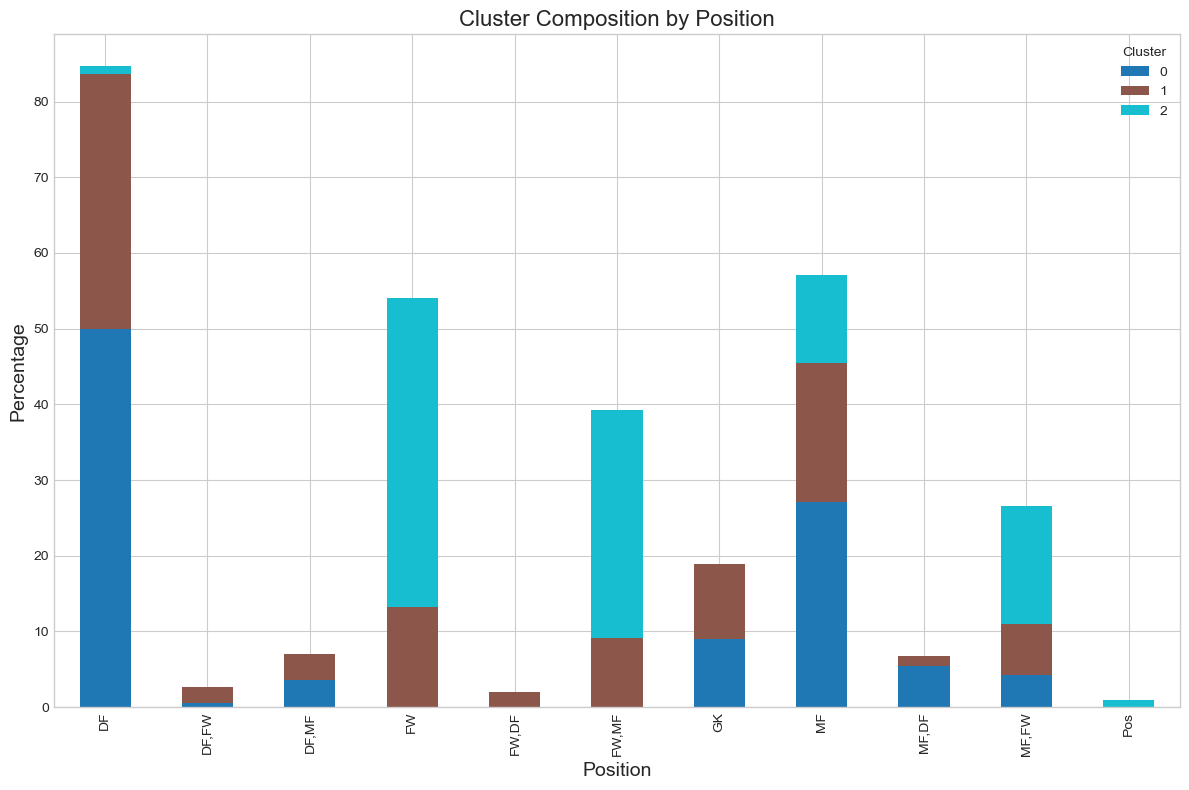


Saving cluster assignments to ../data/processed/player_clusters.csv...
Saved cluster assignments for 563 players


In [37]:
# get cluster assignments from the final model
print(f"Getting cluster assignments from {best_algorithm}...")
cluster_labels = final_model.predict(pca_data)

# create dataframe with cluster assignments
clusters_df = pd.DataFrame({
    'cluster': cluster_labels.astype(int)
})

# add player names if available
if player_names is not None:
    clusters_df.insert(0, 'player', player_names)
    
# add team and position if available
if 'team' in id_df.columns:
    clusters_df['team'] = id_df['team'].values
    
if 'position' in id_df.columns:
    clusters_df['position'] = id_df['position'].values

# display sample of cluster assignments
print("\nSample of cluster assignments:")
print(clusters_df.head())

# count players in each cluster
cluster_counts = clusters_df['cluster'].value_counts().sort_index()
print("\nNumber of players in each cluster:")
for cluster, count in cluster_counts.items():
    print(f"  Cluster {cluster}: {count} players")

# analyze cluster composition by position (if available)
if 'position' in clusters_df.columns:
    print("\nCluster composition by position:")
    position_clusters = pd.crosstab(clusters_df['position'], clusters_df['cluster'])
    print(position_clusters)
    
    # visualize cluster composition by position
    plt.figure(figsize=(12, 8))
    position_clusters_pct = position_clusters.div(position_clusters.sum(axis=0), axis=1) * 100
    position_clusters_pct.plot(kind='bar', stacked=True, colormap='tab10')
    plt.title('Cluster Composition by Position')
    plt.xlabel('Position')
    plt.ylabel('Percentage')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

# save cluster assignments to csv
print(f"\nSaving cluster assignments to {CLUSTERS_OUTPUT_FILE}...")
clusters_df.to_csv(CLUSTERS_OUTPUT_FILE, index=False)
print(f"Saved cluster assignments for {len(clusters_df)} players")

# create a dictionary mapping player names to cluster labels (for later use)
if player_names is not None:
    player_cluster_dict = dict(zip(player_names, cluster_labels))


## 10. UMAP Visualization


In [38]:
# apply umap to pca data for visualization
print(f"Applying UMAP with n_neighbors={UMAP_N_NEIGHBORS}, min_dist={UMAP_MIN_DIST}...")
umap_embedding = apply_umap(
    pca_data,
    n_neighbors=UMAP_N_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    n_components=UMAP_N_COMPONENTS,
    random_state=RANDOM_STATE
)

# create dataframe with umap coordinates
umap_df = pd.DataFrame({
    'x': umap_embedding[:, 0],
    'y': umap_embedding[:, 1],
    'cluster': cluster_labels.astype(int)
})

# add player names if available
if player_names is not None:
    umap_df.insert(0, 'player', player_names)
    
# add team and position if available
if 'team' in id_df.columns:
    umap_df['team'] = id_df['team'].values
    
if 'position' in id_df.columns:
    umap_df['position'] = id_df['position'].values

# display sample of umap coordinates
print("\nSample of UMAP coordinates:")
print(umap_df.head())

# create interactive scatter plot of umap embedding
print("\nGenerating UMAP visualization...")
umap_plot = plot_umap_clusters(umap_embedding, cluster_labels, player_names)
umap_plot.show()

# save umap coordinates to csv
print(f"\nSaving UMAP coordinates to {UMAP_OUTPUT_FILE}...")
umap_df.to_csv(UMAP_OUTPUT_FILE, index=False)
print(f"Saved UMAP coordinates for {len(umap_df)} players")


Applying UMAP with n_neighbors=15, min_dist=0.1...

Sample of UMAP coordinates:
               player         x         y  cluster             team position
0     Aaron Cresswell  5.604086  5.993640        1         West Ham       DF
1      Aaron Ramsdale  9.648052  6.476221        0      Southampton       GK
2   Aaron Wan-Bissaka  1.019172  5.048904        0         West Ham       DF
3  Abdoulaye Doucouré  2.297581  5.242075        0          Everton       MF
4  Abdukodir Khusanov  6.881987  8.450378        1  Manchester City       DF

Generating UMAP visualization...



Saving UMAP coordinates to ../data/processed/player_umap_2d.csv...
Saved UMAP coordinates for 563 players


## 11. Summary and Next Steps


In [39]:
# summarize what we've done
print("Phase 3 Summary:")
print(f"1. Applied PCA to reduce dimensionality while retaining {PCA_VARIANCE_TARGET*100:.0f}% of variance")
print(f"   - Retained {pca.n_components_} principal components")
print(f"2. Evaluated clustering algorithms (K-Means and GMM)")
print(f"   - Selected {best_algorithm.upper()} with {final_k} clusters as the best algorithm")
print(f"   - Silhouette Score: {kmeans_results['silhouette'][K_RANGE.index(optimal_k)]:.4f}")
print(f"   - Davies-Bouldin Index: {kmeans_results['davies_bouldin'][K_RANGE.index(optimal_k)]:.4f}")
print(f"   - Stability (ARI): {kmeans_stability:.4f}")
print(f"3. Applied UMAP for 2D visualization of clusters")
print(f"4. Saved output files:")
print(f"   - {os.path.basename(PCA_OUTPUT_FILE)}")
print(f"   - {os.path.basename(CLUSTERS_OUTPUT_FILE)}")
print(f"   - {os.path.basename(UMAP_OUTPUT_FILE)}")

# summarize cluster distribution
print("\nCluster Distribution:")
for cluster, count in cluster_counts.items():
    percentage = count / len(clusters_df) * 100
    print(f"  Cluster {cluster}: {count} players ({percentage:.1f}%)")

# next steps
print("\nNext Steps (Phase 4):")
print("1. Build explainability tools:")
print("   - Train RandomForest surrogate model")
print("   - Calculate SHAP values for feature importance")
print("   - Compute permutation importance for validation")
print("2. Interpret and name clusters:")
print("   - Analyze cluster centroids")
print("   - Identify representative players for each cluster")
print("   - Assign meaningful role names based on player characteristics")
print("3. Create interactive visualization:")
print("   - Build Streamlit app for exploring player roles")
print("   - Implement radar charts for comparing players")
print("   - Add search functionality for finding similar players")


Phase 3 Summary:
1. Applied PCA to reduce dimensionality while retaining 90% of variance
   - Retained 31 principal components
2. Evaluated clustering algorithms (K-Means and GMM)
   - Selected KMEANS with 3 clusters as the best algorithm
   - Silhouette Score: 0.2455
   - Davies-Bouldin Index: 1.5658
   - Stability (ARI): 0.9143
3. Applied UMAP for 2D visualization of clusters
4. Saved output files:
   - player_pca_projection.csv
   - player_clusters.csv
   - player_umap_2d.csv

Cluster Distribution:
  Cluster 0: 166 players (29.5%)
  Cluster 1: 294 players (52.2%)
  Cluster 2: 103 players (18.3%)

Next Steps (Phase 4):
1. Build explainability tools:
   - Train RandomForest surrogate model
   - Calculate SHAP values for feature importance
   - Compute permutation importance for validation
2. Interpret and name clusters:
   - Analyze cluster centroids
   - Identify representative players for each cluster
   - Assign meaningful role names based on player characteristics
3. Create intera